In [271]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import sys 
sys.path.append('..')
from utils.dataloader import load_data, create_count_data
from utils.plotting_functions import plot_histograms, plot_time_series, ts_percentile

pio.templates.default = "plotly_white"

#plt.style.use('ggplot')
pd.set_option('display.max_columns', None)


ImportError: cannot import name 'ts_percentile' from 'utils.plotting_functions' (/Users/julian/Documents/GitHub/Thesis/notebooks/../utils/plotting_functions.py)

In [2]:
df = load_data()
df.loc[df['Station Name'] == 'PALO ALTO CA / BRYANT # 1', 'Station Name'] =  'PALO ALTO CA / BRYANT #1'

In [454]:
def create_hub_name(station):
   hub_name = station.rsplit('/', 1)[1].lstrip().rsplit(' ', 1)[0]
   if hub_name == 'BRYANT #':
      return 'BRYANT'
   else: 
      return hub_name

def count_plugs(station, station_list, no_plug_list):
   no_plugs = len(df['Port Number'].loc[df['Station Name'] == station].unique())
   return no_plugs
   '''if 'SHERMAN' in station:
      return 2
   else: 
      return no_plugs'''

In [455]:
## Add hub colu,n
df['Hub'] = df['Station Name'].apply(create_hub_name)

In [456]:
port_num = []
station_name = []
j = 0
for i in df['Station Name'].unique():
    station_name.append(i)
    df_port_num = df['Port Number'].loc[df['Station Name'] == i].unique()
    port_num.append(int(len(df_port_num)))

plug_per_station = dict(zip(station_name, port_num))


In [457]:
## Poulate variable no. of plugs with plugs pr. unique station
df['No. Plugs'] = np.zeros(len(df))
for key, value in plug_per_station.items():
    df.loc[df['Station Name'] == key, ['No. Plugs']] = value

In [459]:
## Find first time a specific plug at a specific station is in use
list_of_first_records = []
for i in df['Station Name'].unique():
    list_of_first_records.append(df[df['Station Name'] == i].iloc[0].values)
df_charging_stations = pd.DataFrame(list_of_first_records)
df_charging_stations = df_charging_stations.set_axis(df.columns.unique().values, axis=1, inplace=False)

In [460]:
## Count no. of charging stations pr. hub over time
df_charging_stations['No. Stations'] = df_charging_stations.groupby('Hub').cumcount()
df_charging_stations['No. Stations'] = df_charging_stations['No. Stations'] + 1
df_charging_stations['No. Plugs per Hub'] = df_charging_stations.groupby('Hub').cumsum()['No. Plugs']
df_charging_stations_per_hub = df_charging_stations[['Station Name', 'Start Date', 'Port Number', 'Hub', 'No. Stations', 'No. Plugs per Hub']]

In [461]:
## Create df with time and hubs as rows and columns respectively. Filled with number of charging stations
df_hub = df_charging_stations_per_hub.pivot_table(values='No. Stations', index=['Start Date'], columns='Hub', aggfunc='first')
df_hub = df_hub.fillna(0)
df_hub = df_hub.replace(to_replace=0, method='ffill')

In [462]:
df_plug_hub = df_charging_stations_per_hub.pivot_table(values='No. Plugs per Hub', index=['Start Date'], columns='Hub', aggfunc='first')
df_plug_hub = df_plug_hub.fillna(0)
df_plug_hub = df_plug_hub.replace(to_replace=0, method='ffill')

<AxesSubplot:title={'center':'No. of plugs pr. hub ($\\tau$)'}, xlabel='Start Date'>

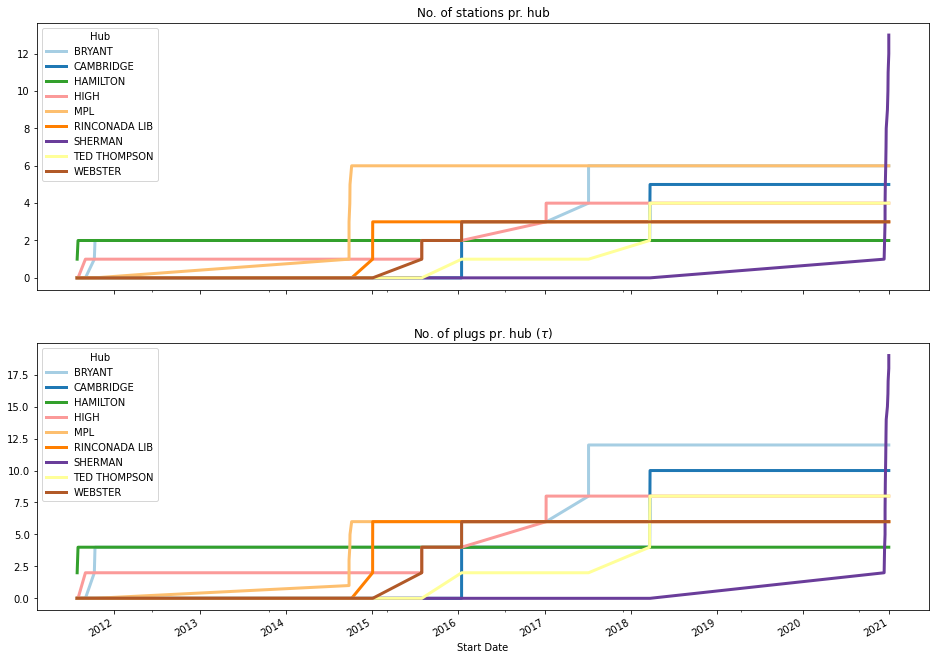

In [463]:
fig, axes = plt.subplots(2, figsize=(16,12), sharex=True)
df_hub.plot(colormap = 'Paired', linewidth = 3, title = 'No. of stations pr. hub', ax=axes[0])
df_plug_hub.plot(colormap = 'Paired', linewidth = 3, title = r'No. of plugs pr. hub ($\tau$)', ax=axes[1])

## Exploring distributions from when the models begin recording

In [47]:
## Read count data format
df_event = pd.read_csv('/Users/julian/Documents/GitHub/Thesis/data/charging_session_count_30_viz.csv', index_col=0, parse_dates=['Period'])

#df_event = create_count_data(df, interval_length = 30, save = True)

In [ ]:
## Getting first record of each station 
first_date_rec = []
j = 0

for i in df_charging_stations['Hub'].unique():
    first_recording = df_charging_stations['Start Date'].loc[df_charging_stations['Hub'] == i].iloc[0]
    first_date_rec.append(first_recording)
    

station_name = df_event.columns.values
hub_start_dict = dict(zip(station_name, first_date_rec))


In [265]:
#plot_list = df_event.columns.values
def plot_histograms(df_in, plot_best_estimate = False, save_figure = False):
    from scipy.optimize import curve_fit
    from scipy.stats import poisson
    
    plot_list = df_in['Cluster'].unique()[:-1]
    
    fig, axes = plt.subplots(4,2, figsize=(12, 16))
    i = 0
    j = 0
    for key in plot_list:
        cluster_events = df_in['Sessions'].loc[df_in['Cluster'] == key]
        cluster_mean = np.mean(df_in['Sessions'].loc[df_in['Cluster'] == key])
        cluster_sd = np.std(df_in['Sessions'].loc[df_in['Cluster'] == key])

        #cluster_events = df_event[key].values
        #cluster_mean = np.mean(cluster_events)
        #cluster_sd = np.std(cluster_events)

        entries, bin_edges, patches  = axes[i,j].hist(cluster_events, bins = range(int(np.max(cluster_events))+3), 
                                                      rwidth=0.7, density = True)
        axes[i,j].set_title(str(key))
        axes[i,j].plot()
        axes[i,j].set_xticks(np.arange(np.max(cluster_events)+3) + 0.5)
        axes[i,j].set_xticklabels(np.arange(np.max(cluster_events)+3))
        
        textstr = '\n'.join((
        r'$\mu=%.2f$' % (cluster_mean, ),
        r'$\sigma=%.2f$' % (cluster_sd, )))

        if (plot_best_estimate == True):
            
            # calculate bin centers
            middles_bins = (bin_edges[1:] + bin_edges[:-1]) * 0.5

            def fit_function(k, lamb):
                # The parameter lamb will be used as the fit parameter
                return poisson.pmf(k, lamb)


            # fit with curve_fit
            parameters, cov_matrix = curve_fit(fit_function, middles_bins, entries)

            # plot poisson-deviation with fitted parameter
            x_plot = np.arange(0, np.max(cluster_events)+3)

            axes[i,j].plot(
                x_plot,
                fit_function(x_plot, *parameters),
                marker='D', linestyle='-',
                color='red',
                label='Fit result',
            )
            textstr = '\n'.join([textstr,
            r'$\lambda=%.2f$' % (parameters, )])     
    
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axes[i,j].text(0.83, 0.962, textstr, transform=axes[i,j].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        
        i += 1
        if i == 4:
            j += 1
            i = 0

    fig.tight_layout()
    if (save_figure == True):
        fig.savefig("/Users/julian/Documents/GitHub/Thesis/Figures/Distributions.png", bbox_inches='tight')
    return


/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estima

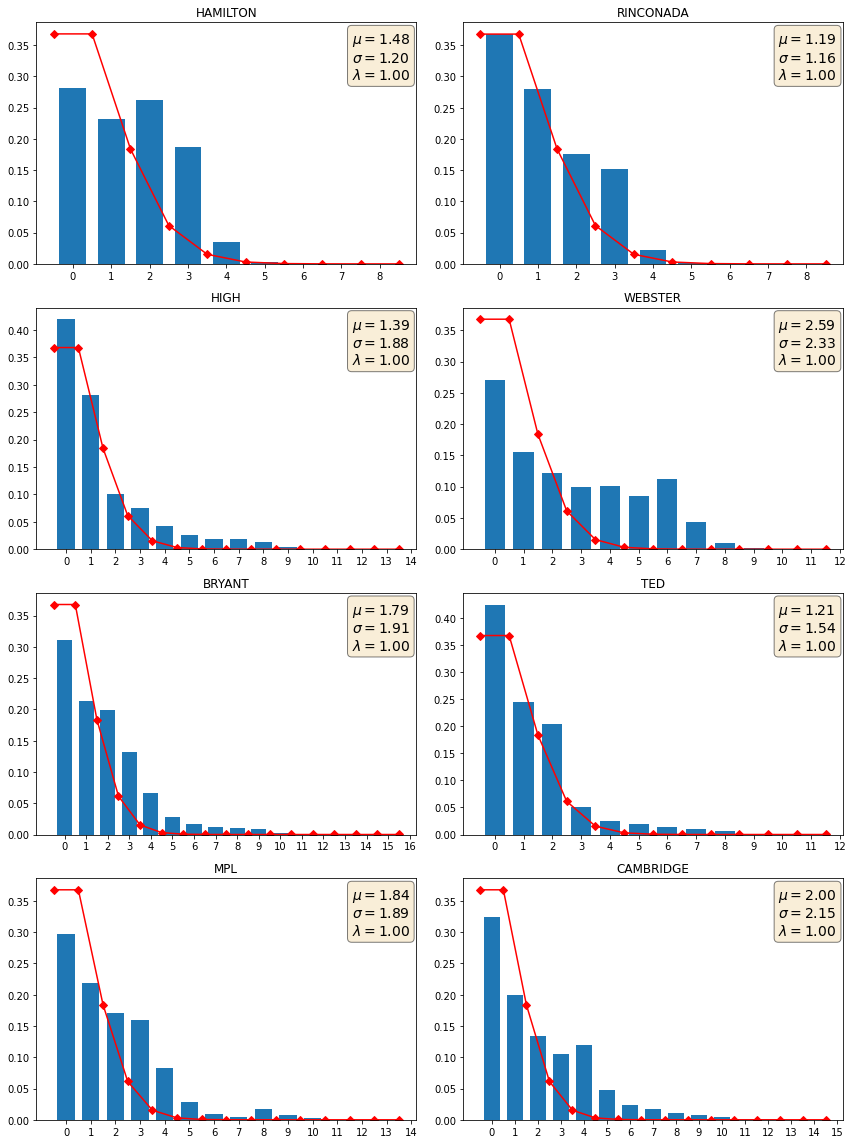

In [266]:
### Could attempt to find best fitted pdf to above distributions
plot_histograms(df_event, plot_best_estimate = True)

## Daily and weekly patterns 
#### Using quantile plots to explore patterns across clusters

In [61]:
## Add day and hour variable
df_event['Day'] = df_event['Period'].dt.dayofweek
df_event['Hour'] = df_event['Period'].dt.hour
plot_list = df_event['Cluster'].unique()[-1]

In [ ]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [ ]:

def tsplot_v2(df, n=2, time_scale = 24, Cluster = 'HAMILTON', value = 'Sessions', percentile_min=10, percentile_max=90, color='r', plot_mean=False, plot_median=True, line_color='k', ax1 = 0, ax2 = 0, plt_axes = axes, **kwargs):
    x = np.arange(0,time_scale)

    # calculate the lower and upper percentile groups, skipping 50 percentile
    perc1 = np.zeros((n, time_scale))
    perc2 = np.zeros((n, time_scale))

    if time_scale == 7:
        group_var = 'Day'
    else: 
        group_var = 'Hour'

    label_list = []
    j = 0
    for i in np.linspace(percentile_min, 50, n)[:-1]:
        perc1[j,:] = df[df['Cluster'] == Cluster].groupby(group_var).agg([percentile(i)])[value].values.flatten()
        label_list.append(i)
        j +=1
    
    k = 0
    for i in np.linspace(50, percentile_max, n)[1:]:
        perc2[k,:] = df[df['Cluster'] == Cluster].groupby(group_var).agg([percentile(i)])[value].values.flatten()
        label_list.append(i)
        k +=1

    if 'alpha' in kwargs:
        alpha = kwargs.pop('alpha')
    else:
        alpha = 1/n
    # fill lower and upper percentile groups
    p = 0
    for p1, p2 in zip(perc1, perc2):
        if (p == n-1):
            label_name = '_nolegend_'
        else:
            label_name = f'{label_list[p]:.0f}-{100-label_list[p]:.0f}% percentile'
        axes[ax1, ax2].fill_between(x, p1, p2, alpha=alpha, color=color, edgecolor=None, label = label_name)
        p += 1

    if plot_mean:
        axes[ax1, ax2].plot(x, df[df['Cluster'] == Cluster].groupby(group_var).mean()[value].values, color=line_color, label = 'Mean')

    if plot_median:
        axes[ax1, ax2].plot(x, df[df['Cluster'] == Cluster].groupby(group_var).median()[value].values, color=line_color)

    return


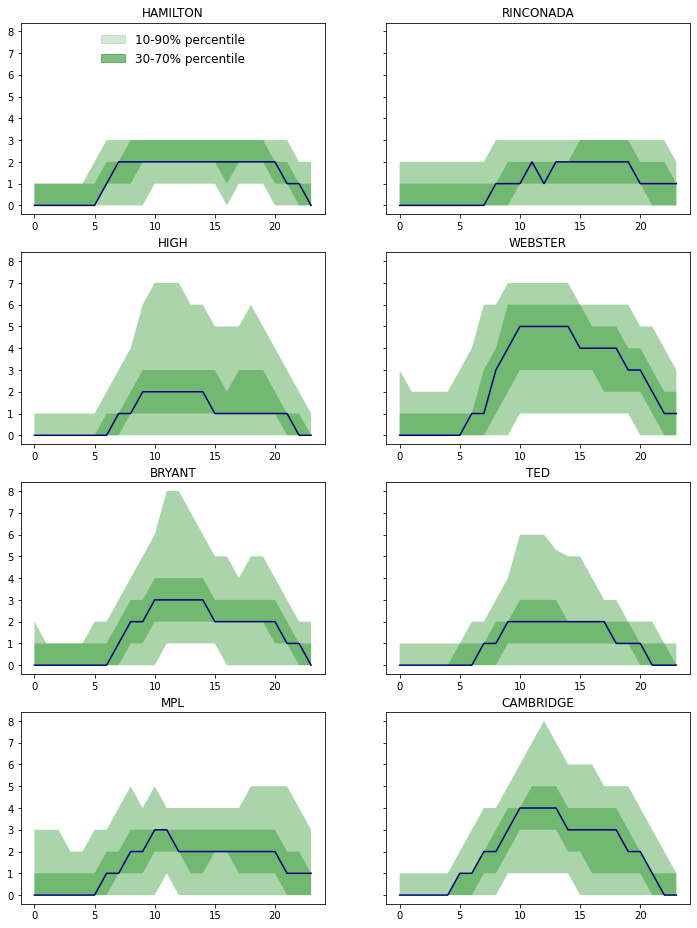

In [ ]:
fig, axes = plt.subplots(4,2, figsize=(12, 18), sharey = True)
i = 0
j = 0
n_percentile = 3
for key in plot_list:
    tsplot_v2(df_event, n=n_percentile, time_scale = 24, Cluster = key, value = 'Sessions', percentile_min=10, percentile_max=90, plot_median=True, plot_mean=False, color='g', line_color='navy', ax1 = i, ax2 = j, plt_axes = axes)
    axes[i,j].set_title(key)
    i += 1
    if i == 4:
        j += 1
        i = 0

legend = axes[0,0].legend(loc="upper center", fontsize=12, markerscale=2, frameon=False)
handles = legend.legendHandles

# There are many more hatches available in matplotlib
for i, handle in (enumerate(handles)):
    handle.set_alpha((i+0.5)*(1/n_percentile))
    handle.set_color('green')

fig.subplots_adjust(bottom=0.2)

#props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#axes[i,j].text(0.5, 0.5, textstr, transform=axes[i,j].transAxes, fontsize=14, verticalalignment='top', bbox=props)


### On consumption

In [ ]:
df_consum = df[['Start Date', 'Cluster', 'Energy (kWh)']]
df_consum['Day'] = df_consum['Start Date'].dt.dayofweek
df_consum['Hour'] = df_consum['Start Date'].dt.hour

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_4131/116872807.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_consum['Day'] = df_consum['Start Date'].dt.dayofweek
/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_4131/116872807.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_consum['Hour'] = df_consum['Start Date'].dt.hour


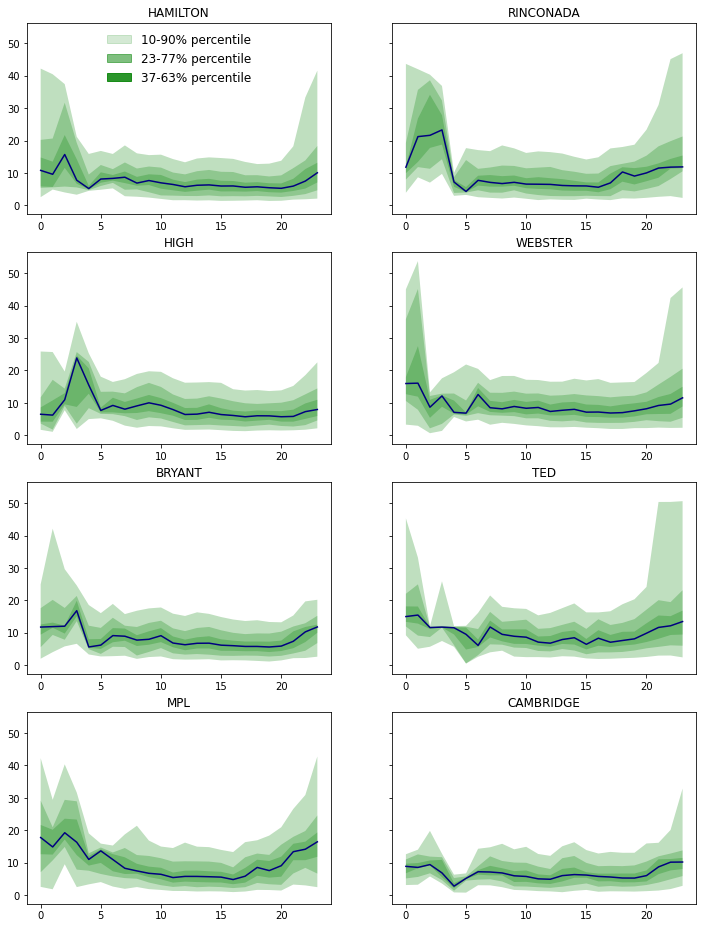

In [ ]:
fig, axes = plt.subplots(4,2, figsize=(12, 18), sharey = True)
i = 0
j = 0

for key in plot_list:
    tsplot_v2(df_consum, n=4, time_scale = 24, Cluster = key, value = 'Energy (kWh)', percentile_min=10, percentile_max=90, plot_median=True, plot_mean=False, color='g', line_color='navy', ax1 = i, ax2 = j, plt_axes = axes)
    axes[i,j].set_title(key)
    i += 1
    if i == 4:
        j += 1
        i = 0

legend = axes[0,0].legend(loc="upper center", fontsize=12, markerscale=2, frameon=False)
handles = legend.legendHandles

# There are many more hatches available in matplotlib
for i, handle in (enumerate(handles)):
    handle.set_alpha((i+0.5)*(1/n_percentile))
    handle.set_color('green')

fig.subplots_adjust(bottom=0.2)
fig.savefig('Figures/ConsumptionPercentiles.png')

### Weekly patterns

In [ ]:
from numpy.random import default_rng
rng = default_rng()

In [ ]:
df_weekly = df_event.groupby(['Cluster','Day']).median()['Sessions']
df_weekly_jittered = df_weekly + 0.05*rng.standard_normal(df_weekly.shape)

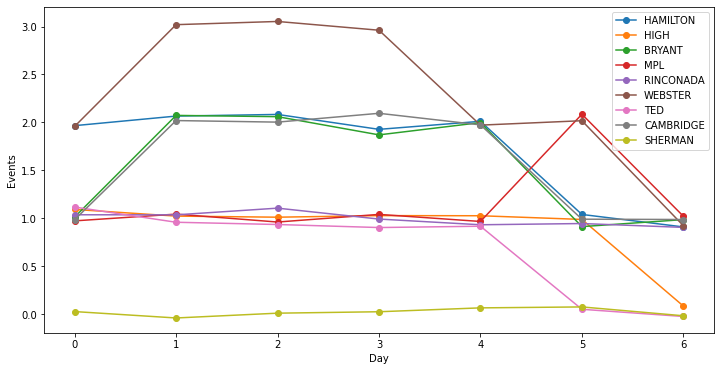

In [ ]:
fig, axes = plt.subplots(figsize=(12,6))
for key in df_event['Cluster'].unique():
    axes.plot(df_weekly_jittered[key], '-o', label = key)
    axes.set_xlabel('Day')
    axes.set_ylabel('Events')
    axes.legend()
plt.show()

## Adding max no. plugs for each cluster at any time point

In [114]:
df_event = pd.read_csv('/Users/julian/Documents/GitHub/Thesis/data/charging_session_count_30_viz.csv', index_col=0, parse_dates=['Period'])
df_event['Day'] = df_event['Period'].dt.dayofweek
df_event['Hour'] = df_event['Period'].dt.hour

In [470]:
## Create start and end date from plugs table
## Uncomment below if name change is necessary
df_charging_stations_per_hub = df_charging_stations_per_hub.rename(columns = {'End Date': 'EndDate', 'Start Date': 'StartDate'})
df_charging_stations_per_hub['EndDate'] = df_charging_stations_per_hub['StartDate'].shift(-1, fill_value= df_event['Period'].iloc[-1])
df_charging_stations_per_hub = df_charging_stations_per_hub.rename(columns = {'Hub': 'Cluster'})

In [471]:
df_charging_stations_per_hub

,Station Name,StartDate,Port Number,Cluster,No. Stations,No. Plugs per Hub,EndDate
0,PALO ALTO CA / HAMILTON #1,2011-07-29 20:17:00,2,HAMILTON,1,2.0,2011-08-02 12:26:00
1,PALO ALTO CA / HAMILTON #2,2011-08-02 12:26:00,2,HAMILTON,2,4.0,2011-09-02 20:42:00
2,PALO ALTO CA / HIGH #4,2011-09-02 20:42:00,2,HIGH,1,2.0,2011-10-10 15:23:00
3,PALO ALTO CA / BRYANT #2,2011-10-10 15:23:00,2,BRYANT,1,2.0,2011-10-13 12:49:00
4,PALO ALTO CA / BRYANT #1,2011-10-13 12:49:00,2,BRYANT,2,4.0,2014-09-24 08:26:00
5,PALO ALTO CA / MPL #4,2014-09-24 08:26:00,1,MPL,1,1.0,2014-09-24 08:36:00
6,PALO ALTO CA / MPL #6,2014-09-24 08:36:00,1,MPL,2,2.0,2014-09-24 08:42:00
7,PALO ALTO CA / MPL #2,2014-09-24 08:42:00,1,MPL,3,3.0,2014-09-27 15:54:00
8,PALO ALTO CA / MPL #1,2014-09-27 15:54:00,1,MPL,4,4.0,2014-09-28 10:45:00
9,PALO ALTO CA / MPL #5,2014-09-28 10:45:00,1,MPL,5,5.0,2014-10-05 09:50:00


In [472]:
## Merge dataframes containing events and the total number of plugs per cluster over time
#df_censored = pd.merge(df_event, df_charging_stations_per_hub, how='inner', left_on='Cluster', right_on='Cluster')
#df_censored = df_censored[(df_censored['Period']>=df_censored['StartDate']) & (df_censored['Period']<=df_censored['EndDate'])]
#df_censored = df_censored[['Period', 'Sessions', 'Cluster', 'Day', 'Hour', 'No. Plugs per Hub']]
#df_censored = df_censored.rename(columns =  {'No. Plugs per Hub': 'PlugCap'})
def assignPlugCap(df_in, df_charging_plugs):
    df_out = df_in.copy()
    

    ## Fix zero values in beginning
    df_charging_plugs.iloc[0]['StartDate'] = '2011-07-29 20:00:00'

    for i in np.arange(len(df_charging_plugs)):
        df_out.loc[(df_out['Cluster'] == df_charging_plugs['Cluster'].iloc[i]) & 
                                        (df_out['Period'] >= df_charging_plugs['StartDate'].iloc[i]) & 
                                        (df_out['Period'] <= df_charging_plugs['EndDate'].iloc[i]),
                                        'PlugCap'] = df_charging_plugs['No. Plugs per Hub'].iloc[i]

    #df_out.sort_values(['Cluster','PlugCap']).groupby('Cluster').ffill()
    df_out = df_out.fillna(method='ffill')
    return df_out

In [474]:
df_censored_v2 = assignPlugCap(df_event, df_charging_stations_per_hub)

/opt/miniconda3/lib/python3.9/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [475]:
#df_censored_v2.to_csv("/Users/julian/Documents/GitHub/Thesis/data/charging_session_count_30_capped_viz.csv")

## Plot sessions and caps scheme

In [224]:
df_censored = pd.read_csv("/Users/julian/Documents/GitHub/Thesis/data/charging_session_count_30_capped.csv", index_col=0, parse_dates=['Period'])

$\eta is the percentage of time intervals where the amount sessions exceed the number of plugs (due to time aggregation)$
$\mu is the average fraction of plugs in use (out of the total number)$


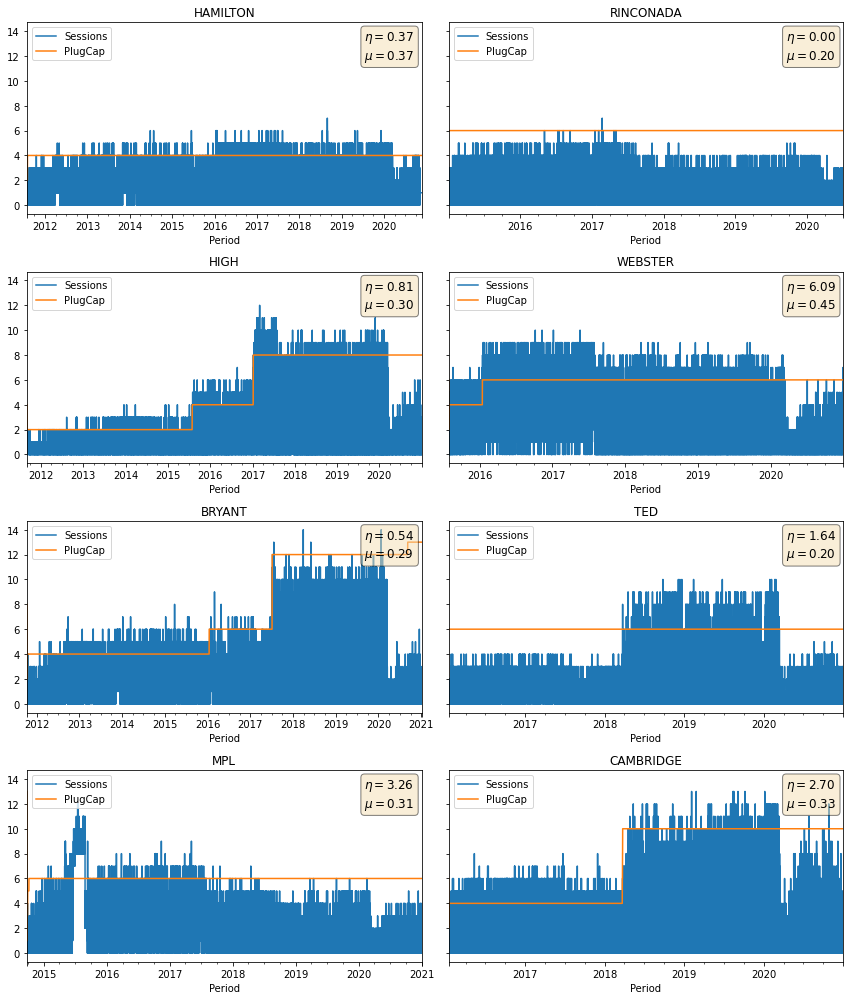

In [285]:
## Given old layout, use this function
plot_time_series(df_censored, save_figure=True)

## Create new datasets (1 minute and 30 minute resolutions) and plot time series

In [482]:
# IF creating for 1 minute interval, use thiss
df_censored = pd.read_csv("/Users/julian/Documents/GitHub/Thesis/data/charging_session_count_1.csv", index_col=0, parse_dates=['Period'])

# If creating for 30 minute interval, use this
#df_censored = pd.read_csv("/Users/julian/Documents/GitHub/Thesis/data/charging_session_count_30_viz.csv", index_col=0, parse_dates=['Period'])

In [483]:
## Assign plug cap
df_censored_minute_cap = assignPlugCap(df_censored, df_charging_stations_per_hub)

/opt/miniconda3/lib/python3.9/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [484]:
def pivot_to_input(df_in, write_to_csv = False):
    minute_resolution = False     
    
    if (len(df_in) > 1500000):
        minute_resolution = True

    df_pivot_sessions = df_in.pivot_table(index='Period', columns='Cluster', values='Sessions')
    df_pivot_plugCap = df_in.pivot_table(index='Period', columns='Cluster', values='PlugCap')

    # Cut timeseries off at the latest timepoint of the cluster with the earliest last timepoint
    df_pivot_sessions_reduced = df_pivot_sessions.loc[:df_censored.groupby('Cluster').agg({'Period': 'max'}).Period.min()].copy()
    df_pivot_plugCap_reduced = df_pivot_plugCap.loc[:df_censored.groupby('Cluster').agg({'Period': 'max'}).Period.min()].copy()
    # Cluster "SHERMAN" has no data before late 2021, so we drop it
    df_pivot_sessions_reduced.drop('SHERMAN', axis=1, inplace=True)
    df_pivot_plugCap_reduced.drop('SHERMAN', axis=1, inplace=True)
    
    # Fill missing values with 0
    df_pivot_sessions_reduced.fillna(0, inplace=True)
    df_pivot_plugCap_reduced.fillna(0, inplace=True)

    ## Rename columns to cap for no. of plugs within cluster
    df_pivot_plugCap_reduced = df_pivot_plugCap_reduced.rename(columns = {'BRYANT': 'BRYANT_CAP', 'CAMBRIDGE': 'CAMBRIDGE_CAP', 'HAMILTON':'HAMILTON_CAP',
                                            'HIGH': 'HIGH_CAP', 'MPL': 'MPL_CAP', 'RINCONADA': 'RINCONADA_CAP', 'TED': 'TED_CAP',
                                            'WEBSTER':'WEBSTER_CAP'})
    
    ## Merge datasets on index
    df_sessions_cap = df_pivot_sessions_reduced.join(df_pivot_plugCap_reduced)

    if (minute_resolution == True):
        df_sessions_cap['Period'] = df_sessions_cap.index.values
        df_sessions_cap = df_sessions_cap.resample('30T', on='Period').max()
        df_sessions_cap = df_sessions_cap.drop(columns = ['Period'])
        out_name = "1_to_30"

    if (write_to_csv == True):
        out_name = "30"
        df_sessions_cap.to_csv('/Users/julian/Documents/GitHub/Thesis/data/charging_session_count_{out_name}_capped.csv')

    return df_sessions_cap

In [487]:
## Constant censoring 
df_censored_cap = pivot_to_input(df_censored_minute_cap, write_to_csv = True)

In [333]:
df_censored_cap = pd.read_csv("/Users/julian/Documents/GitHub/Thesis/data/charging_session_count_1_to_30_capped.csv")

In [500]:
print(len(df_censored_cap.columns[1:8].values))
print(len(df_censored_cap.columns[9:].values))


7
7


In [503]:
print((df_censored_cap.columns[0:8].values))
print((df_censored_cap.columns[8:].values))


['BRYANT' 'CAMBRIDGE' 'HAMILTON' 'HIGH' 'MPL' 'RINCONADA' 'TED' 'WEBSTER']
['BRYANT_CAP' 'CAMBRIDGE_CAP' 'HAMILTON_CAP' 'HIGH_CAP' 'MPL_CAP'
 'RINCONADA_CAP' 'TED_CAP' 'WEBSTER_CAP']


In [495]:
np.arange(len(df_censored_cap.columns[1:9].values))



array([0, 1, 2, 3, 4, 5, 6, 7])

In [497]:
np.arange(len(df_censored_cap.columns[9:].values))

array([0, 1, 2, 3, 4, 5, 6])

In [615]:
df_censored_cap.ne(0).idxmax()['BRYANT']

Timestamp('2011-10-10 15:00:00')

In [617]:
df_censored_cap.index.get_loc(df_censored_cap.ne(0).idxmax()['BRYANT'])

3494

In [629]:
def plot_time_series_2(df_in, save_figure = False, is_censored = False):
    plot_list_sessions = df_in.columns[0:8].values
    plot_list_capacity = df_in.columns[8:].values

    if (is_censored == True):
        plot_list_censored = plot_list_sessions + '_CENSORED'

    fig, axes = plt.subplots(4,2, figsize=(12, 14), sharey = True, sharex = True)
    i = 0
    j = 0
    for key in np.arange(len(plot_list_sessions)):
        session_name = plot_list_sessions[key]
        cap_name = plot_list_capacity[key]
        if (is_censored == True):
            censored_name = plot_list_censored[key]

        df_in.plot(y = [session_name, cap_name, censored_name], ax = axes[i,j], label = ['Sessions', 'Plug capacity', r'$\tau$'])
        
        axes[i,j].set_title(session_name)
        axes[i,j].legend(loc = 'upper left')

        no_events = len(df_in)
        no_exceed_plugcap = (len(df_in[df_in[session_name] > df_in[cap_name]]) / no_events)*100
        usage_fraction = np.mean(df_in[session_name] / df_in[cap_name])

        textstr = '\n'.join((
        r'$\eta =%.2f$' % (no_exceed_plugcap, ),
        r'$\mu =%.2f$' % (usage_fraction , )))

        if (is_censored == True):
            idx_nonzero = df_in.index.get_loc(df_in.ne(0).idxmax()[key])
            no_censored = df_in[session_name + '_IS_CENSORED'].sum() / len(df_in.iloc[idx_nonzero:])

            textstr = r'$\eta =%.2f$' % (no_censored)

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axes[i,j].text(0.855, 0.962, textstr, transform=axes[i,j].transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

        i += 1
        if i == 4:
            j += 1
            i = 0
    fig.tight_layout()
    print(r'$\eta is the percentage of time intervals where the amount sessions exceed the number of plugs (due to time aggregation)$')
    print(r'$\mu is the average fraction of plugs in use (out of the total number)$')

    if (save_figure == True):
        fig.savefig("/Users/julian/Documents/GitHub/Thesis/Figures/Time_series_{start_date}_{end_date}.png", bbox_inches='tight')


UnboundLocalError: local variable 'plot_list_censored' referenced before assignment

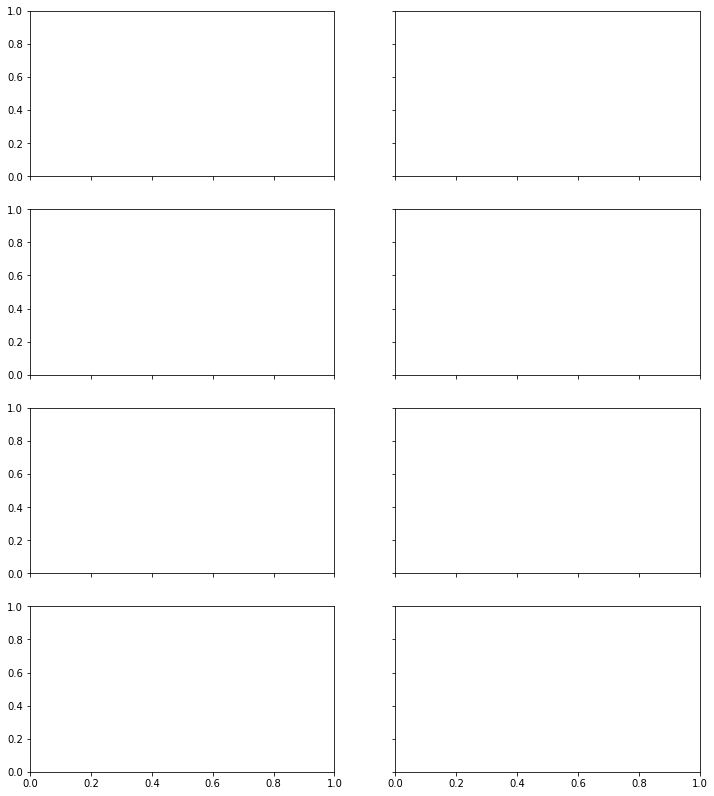

In [628]:
plot_time_series_2(df_censored_cap)

## Censoring variables dependent on time

In [584]:
print(df_censored_cap.columns[0:8].values)
print(df_censored_cap.columns[8:].values)

['BRYANT' 'CAMBRIDGE' 'HAMILTON' 'HIGH' 'MPL' 'RINCONADA' 'TED' 'WEBSTER']
['BRYANT_CAP' 'CAMBRIDGE_CAP' 'HAMILTON_CAP' 'HIGH_CAP' 'MPL_CAP'
 'RINCONADA_CAP' 'TED_CAP' 'WEBSTER_CAP']


In [656]:

def static_censor(df_in, censor_threshold = [2,2,2,2,2,2,2,2], min_tot_plugs = [4,4,4,4,4,4,4,4], censor_scheme = 2, to_train_data = False):
    ## df_in: df to copy and add aditional columns
    ## censor_threshold: the number is subtracted from the total number of plugs. This will be the observed number of events from the model
    ## min_session_observed: the minimum number of plugs that should be present, before censoring is applied

    df_out = df_in.copy()

    plot_list_sessions = df_in.columns[0:8].values
    plot_list_capacity = df_in.columns[8:].values
    df_size = len(df_out)

    for i in np.arange(len(plot_list_sessions)): 
        session_name = plot_list_sessions[i]
        cap_name = plot_list_capacity[i]        
        
        df_out[session_name + '_CENSORED'] = df_out[cap_name]
        #df_out[session_name + '_CENSORED'] = df_out[cap_name]
        df_out[session_name + '_IS_CENSORED'] = np.zeros(df_size)

        #df_out.loc[(df_out[cap_name] >= min_tot_plugs[i]) &
        #           (df_out[session_name] > (df_out[cap_name]-censor_threshold[i])),
        #           [session_name + '_CENSORED', session_name + '_IS_CENSORED']] = [(df_out[cap_name].iloc[0]-censor_threshold[i]), 1]
        
        if (censor_scheme == 1):
            df_out.loc[(df_out[cap_name] >= min_tot_plugs[i]), session_name + '_CENSORED'] =  censor_threshold[i]
            df_out.loc[(df_out[session_name] > df_out[session_name + '_CENSORED']), session_name + '_IS_CENSORED'] =  1

            if (to_train_data == True):
                df_out.loc[(df_out[session_name + '_IS_CENSORED'] == 1), session_name] = df_out[session_name + '_CENSORED']
                df_out[cap_name] = df_out[session_name + '_CENSORED']
                
                df_out = df_out.rename(columns = {cap_name: session_name + '_TAU'})

        elif(censor_scheme == 2):
            df_out.loc[(df_out[cap_name] >= min_tot_plugs[i]), session_name + '_CENSORED'] =  (df_out[cap_name]-censor_threshold[i])
            df_out.loc[(df_out[session_name] > df_out[session_name + '_CENSORED']), session_name + '_IS_CENSORED'] =  1
            
            if (to_train_data == True):
                df_out.loc[(df_out[session_name + '_IS_CENSORED'] == 1), session_name] = df_out[session_name + '_CENSORED']            
                df_out[cap_name] = df_out[session_name + '_CENSORED']

                df_out = df_out.rename(columns = {cap_name: session_name + '_TAU'})
                
        elif(censor_scheme == 3):
            ## random censoring given percentage 
            NotImplemented

        #(df_out[session_name] > (df_out[cap_name]-censor_threshold[i])),

        
    if (to_train_data == True):
        df_out = df_out.drop(columns = plot_list_sessions + '_IS_CENSORED')
        df_out = df_out.drop(columns = plot_list_sessions + '_CENSORED')

    return df_out

In [663]:
df_censored_train = static_censor(df_censored_cap, censor_scheme = 2)

$\eta is the percentage of time intervals where the amount sessions exceed the number of plugs (due to time aggregation)$
$\mu is the average fraction of plugs in use (out of the total number)$


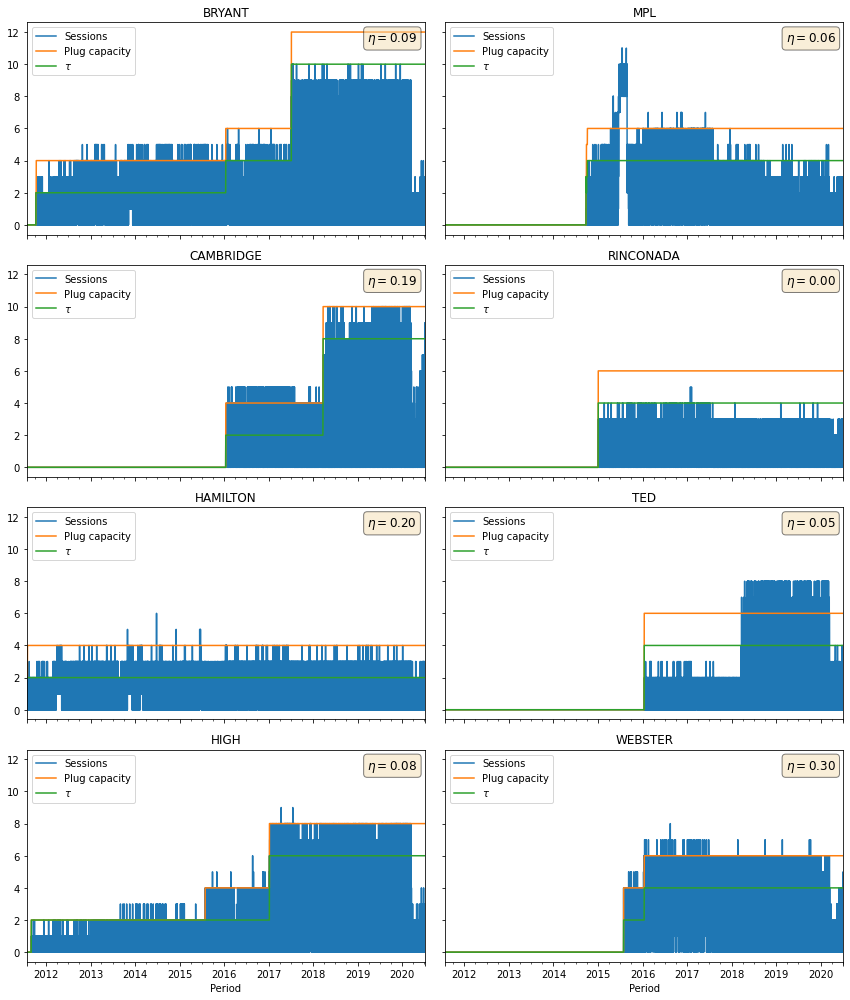

In [664]:
plot_time_series_2(df_censored_train, is_censored = True)